# This file creates the adjacency matrices of logging concessions and does some exploratory analysis on degree over the years

- slides 5 and onward in cells.pptx illustrates some results

In [6]:
# imports
import numpy as np
import matplotlib as mpl
# from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import descartes
gdf = gpd.read_file("data/Managed_Forest_Concessions_(WRI).geojson")


# logging concessions

<AxesSubplot:>

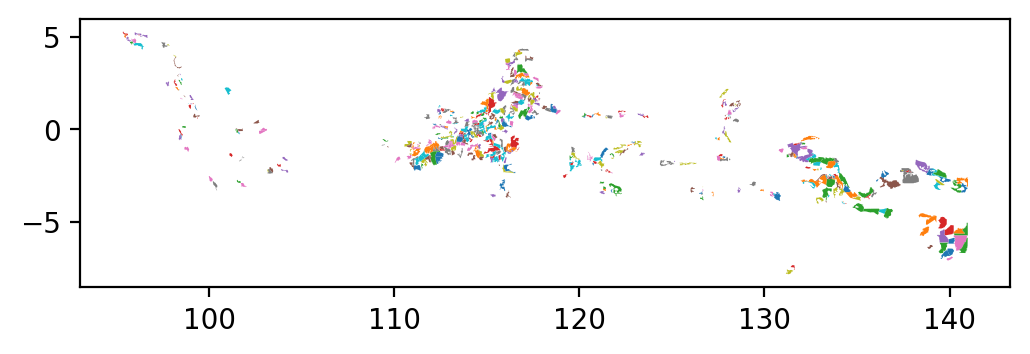

In [5]:
# plot map, color by area
mpl.rcParams['figure.dpi'] = 200 # set dpi
gdf.plot("area_ha", legend=False) 

<AxesSubplot:>

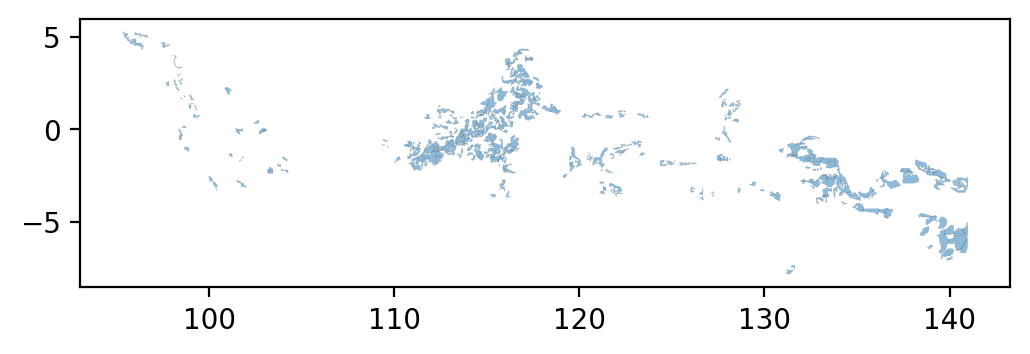

In [4]:
# optionally add a buffer to each concession 
# (e.g. buffer size of 1 = concessions within 69*2 would be adjacent/considered neighbors in the adjacency matrix))

# One degree of latitude equals approximately 364,000 feet (69 miles), one minute equals 6,068 feet (1.15 miles), and one-second equals 101 feet. 
gdf["buffered"] = gdf.buffer(.00) # set buffer
ax = gdf.set_geometry('buffered').plot(alpha=.5) # saving the first plot as an axis and setting alpha (transparency) to 0.5
gdf.plot(ax=ax, facecolor = "none", edgecolor="black", linewidth=.02) # passing the first plot

In [5]:
# implement year column
# note: there's a weird 26 ending - legal term 522.21-26 - unsure how to handle, leave this concession out in later calculations (e.g. filter out the year 2026)
years = [i[-2:] for i in gdf['legal_term']]
gdf["year"] = ["19"+i  if int(i) > 30 else "20"+i for i in years]
unique = np.unique(gdf["year"])
print(len(unique), unique)

26 ['1978' '1983' '1985' '1987' '1988' '1989' '1990' '1991' '1992' '1993'
 '1994' '1995' '1996' '1997' '1998' '1999' '2000' '2001' '2002' '2004'
 '2005' '2006' '2007' '2008' '2009' '2026']


### exploratory analysis: plot ofs the number and areas of logging concessions introduced by year and cumulatively over time

results: 
- trends/distributions for areas is the same as for the counts
- steadily increase over time, with larger increases in 2000, 2006, 2009
- overall, more concessions instated after 2000 than before 2000
- no new concessions in 2003


[('1978', 1), ('1983', 1), ('1985', 1), ('1987', 9), ('1988', 21), ('1989', 17), ('1990', 12), ('1991', 23), ('1992', 28), ('1993', 20), ('1994', 14), ('1995', 11), ('1996', 7), ('1997', 16), ('1998', 9), ('1999', 46), ('2000', 63), ('2001', 22), ('2002', 7), ('2003', 0), ('2004', 35), ('2005', 22), ('2006', 75), ('2007', 24), ('2008', 12), ('2009', 57)]


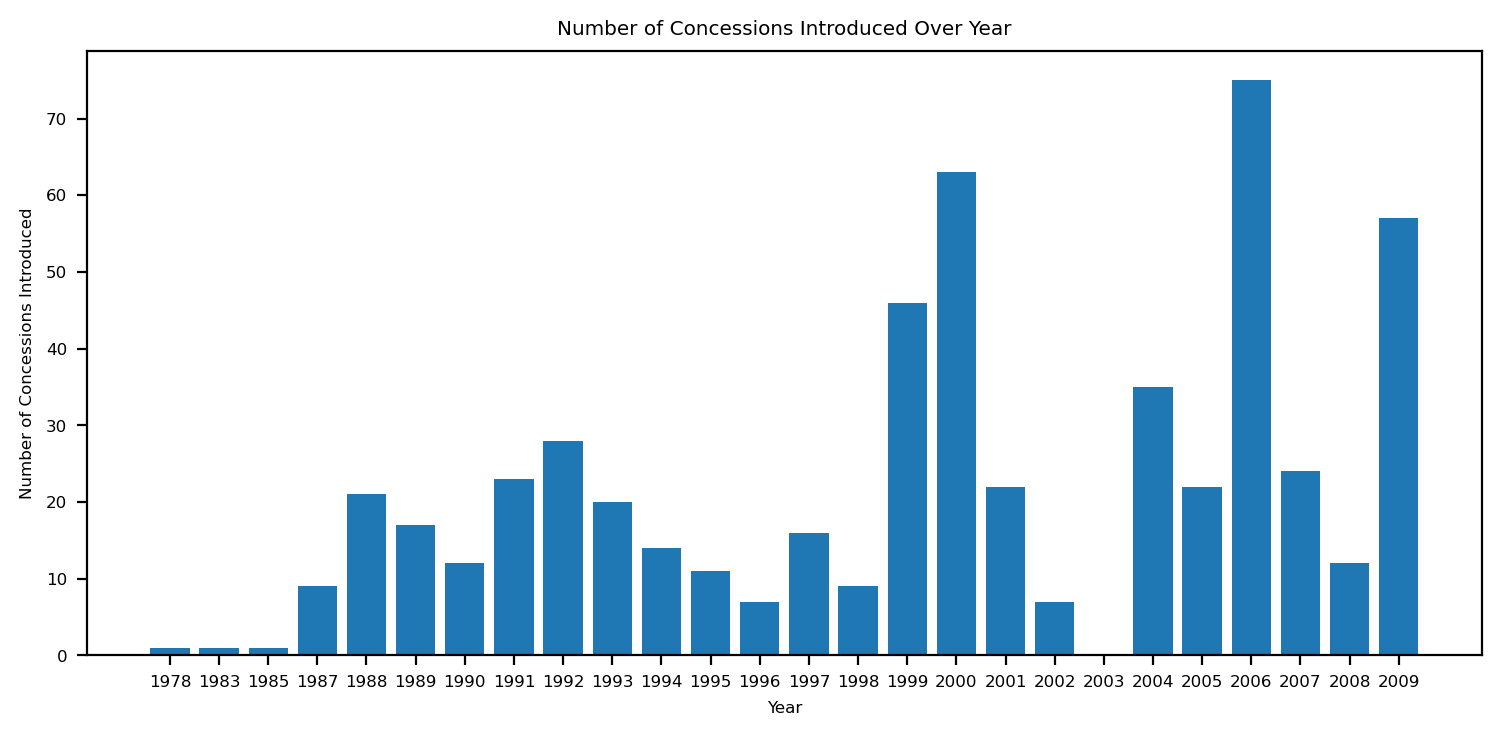

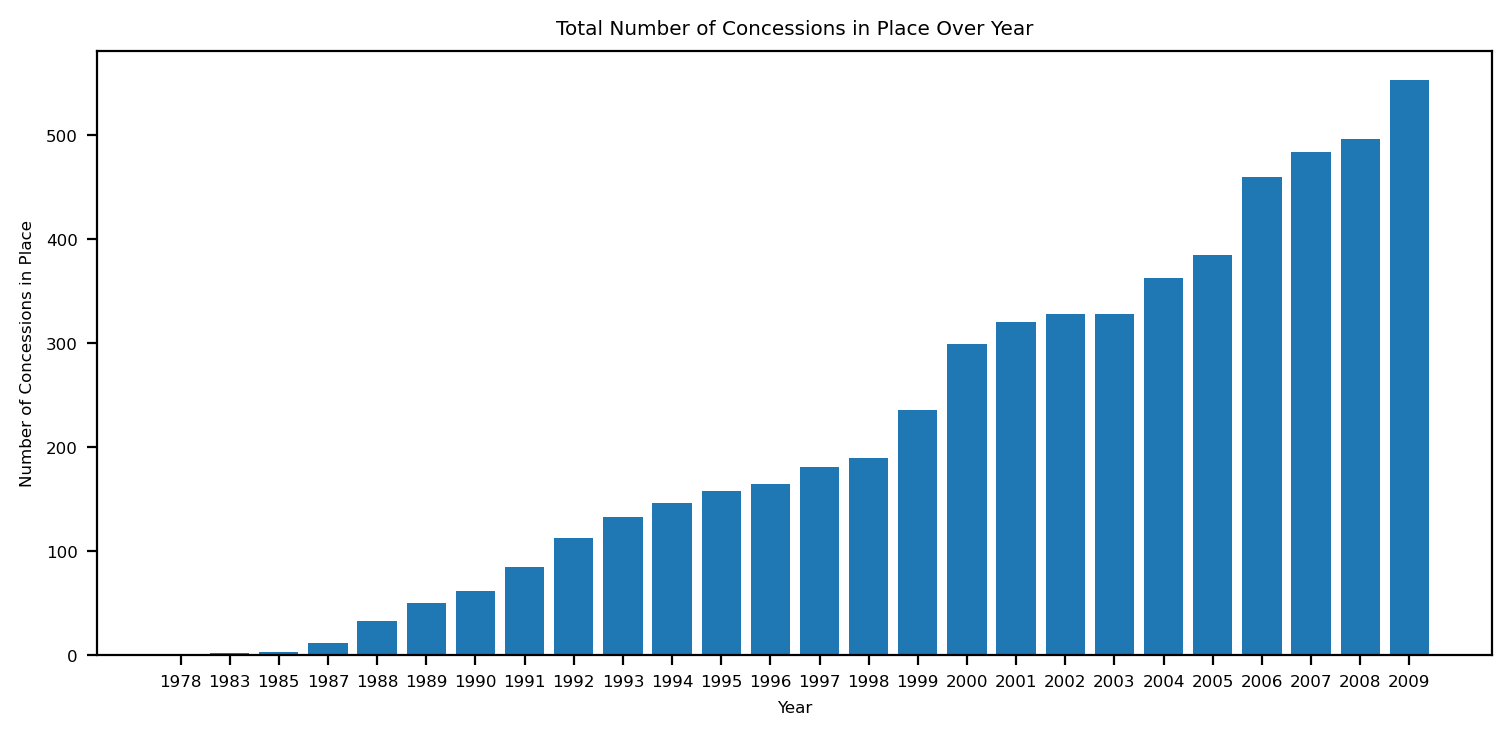

In [92]:
# plot the number of logging concessions introduced by year and cumulatively over time

from collections import Counter
plt.rcParams.update({'font.size': 6})

conc_count_by_yr = Counter(gdf["year"]) # list of (year, count) tuples for concessions introduced each year
conc_count_by_yr['2003'] = 0
conc_count_by_yr = sorted(conc_count_by_yr.items())[:-1] # sort, ignore the wack 26 term 
print(conc_count_by_yr)

keys = [i[0] for i in conc_count_by_yr]
vals = [i[1] for i in conc_count_by_yr]
cumul_vals = [sum(vals[:i+1]) for i in range(len(vals))] # cumulative count

# plot change in number per year
plt.figure(figsize=(9, 4))
plt.bar(keys, vals)
plt.title("Number of Concessions Introduced Over Year")
plt.xlabel("Year")
plt.ylabel("Number of Concessions Introduced")
plt.show()

# plot cumulative count per year
plt.figure(figsize=(9, 4))
plt.bar(keys, cumul_vals)
plt.title("Total Number of Concessions in Place Over Year")
plt.xlabel("Year")
plt.ylabel("Number of Concessions in Place")
plt.show()

['1978' '1983' '1985' '1987' '1988' '1989' '1990' '1991' '1992' '1993'
 '1994' '1995' '1996' '1997' '1998' '1999' '2000' '2001' '2002' '2003'
 '2004' '2005' '2006' '2007' '2008' '2009']
[9159.0, 90296.0, 167883.0, 284298.0, 254678.0, 836501.0, 1007575.0, 1538000.0, 1585047.0, 1569264.0, 877169.0, 1130502.0, 766596.0, 1571993.0, 622160.0, 2601286.0, 1647027.0, 926399.0, 186817.0, 0, 1637837.0, 1053515.0, 2378853.0, 597370.0, 567733.0, 3776694.0]


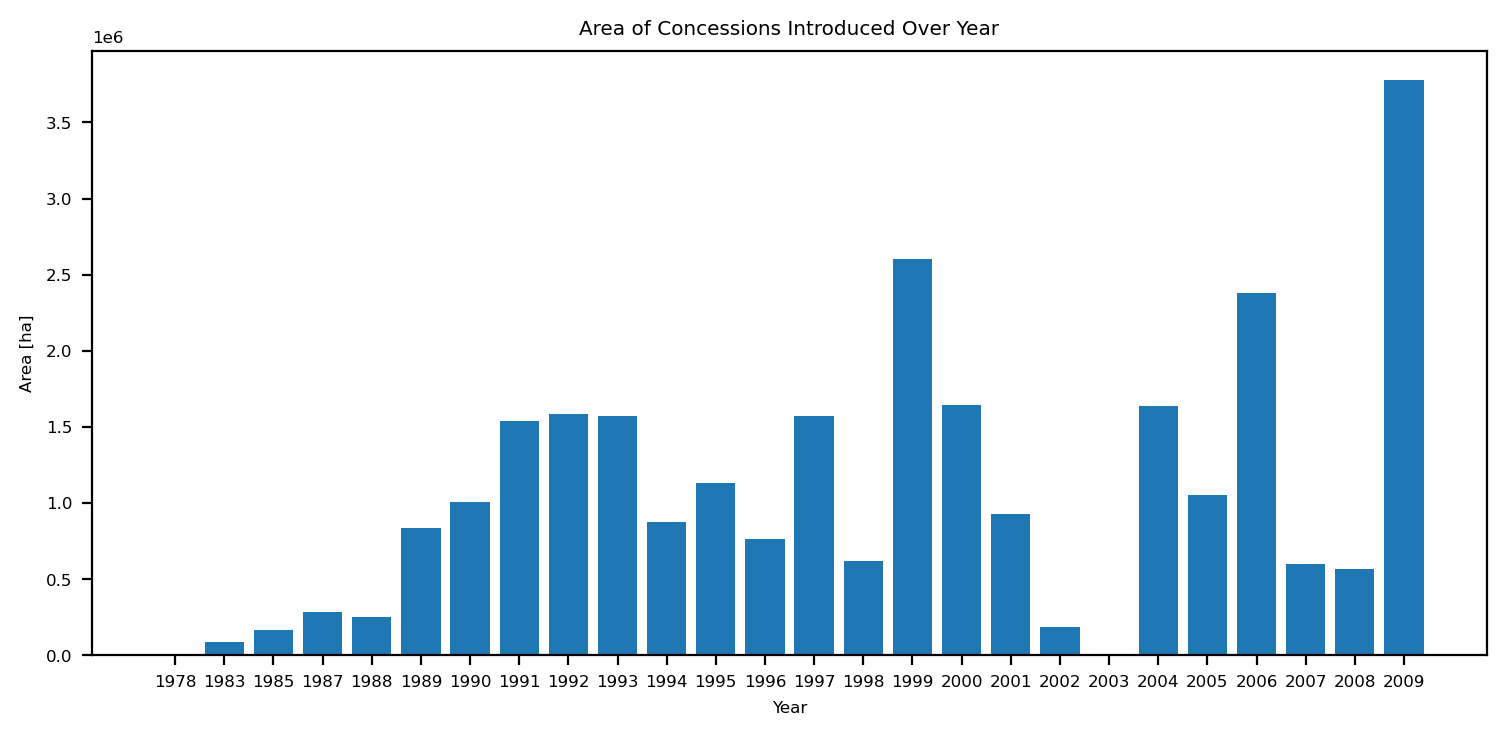

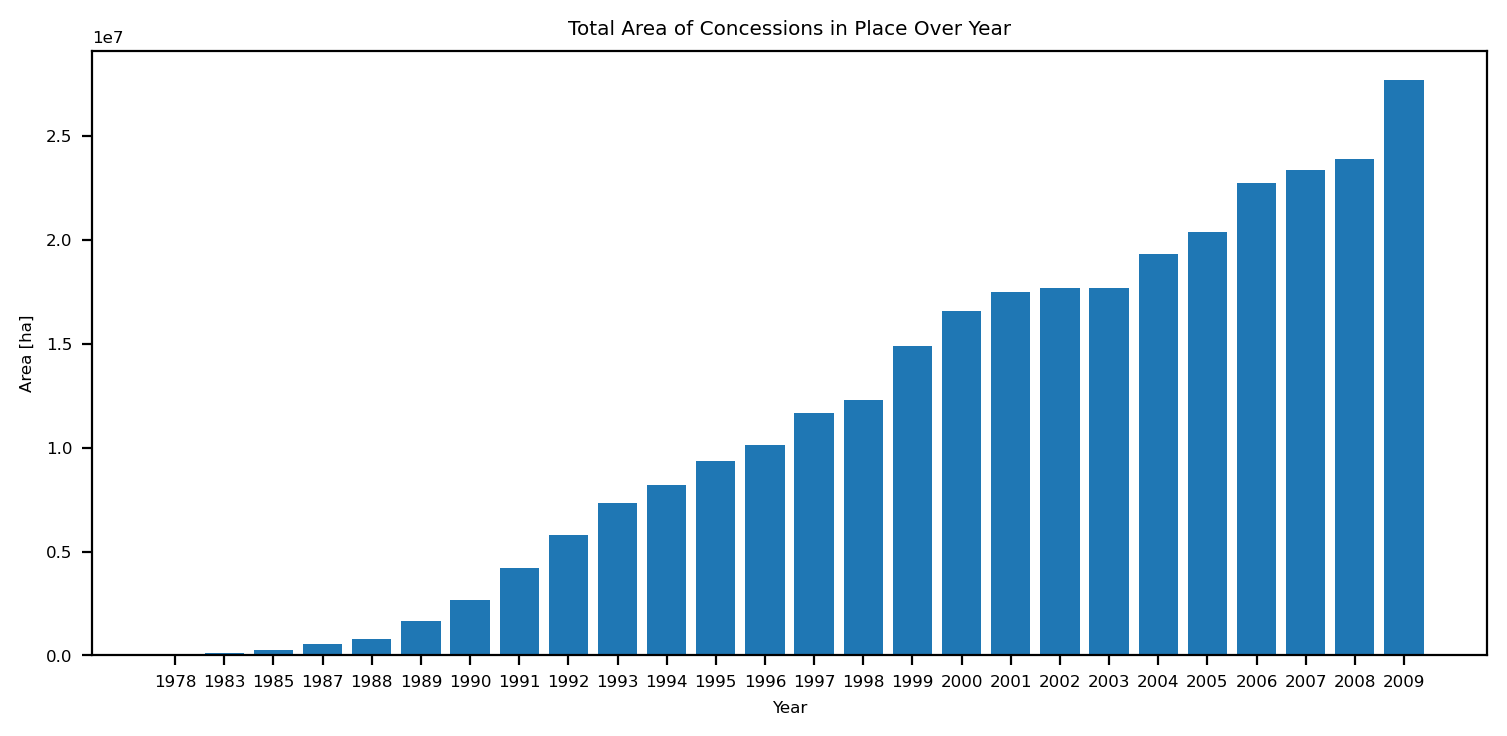

In [95]:
#plot the area of logging concessions introduced by year and cumulatively over time

years = np.insert(np.unique(gdf['year'])[:-1], -6, '2003') # get all years concessions were added, ignore the weird 26 thing
print(years)
conc_by_yr = {}
conc_areas_by_year = {}

for year in years:
    conc_by_yr[year] = [i for i in range(len(gdf)) if gdf["year"][i] == year]
    conc_areas_by_year[year] = sum([float(gdf['area_ha'][i]) for i in conc_by_yr[year]])

keys = list(conc_areas_by_year.keys())
vals = list(conc_areas_by_year.values())
cumul_vals = [sum(vals[:i+1]) for i in range(len(vals))] # cumulative count

# plot change in area per year
plt.figure(figsize=(9, 4))
plt.bar(keys, vals)
plt.title("Area of Concessions Introduced Over Year")
plt.xlabel("Year")
plt.ylabel("Area [ha]")
plt.show()

# plot cumulative area per year
plt.figure(figsize=(9, 4))
plt.bar(keys, cumul_vals)
plt.title("Total Area of Concessions in Place Over Year")
plt.xlabel("Year")
plt.ylabel("Area [ha]")
plt.show()

### generating the adjacency matrix for logging concessions
a_ij = 1 if logging concession i and logging concession j overlap, 0 elsewise or if i=j

In [7]:
# create adjacency matrix - 2d np array
adj_mat = []
for indx, polygon in enumerate(gdf.loc[:, "geometry"]):
    row = gdf.set_geometry("buffered").intersects(polygon).astype(int) # compute adjacencies (1 is adjacent, 0 elsewise)
    row[indx] = 0 # region should not be considered adjacent to itself
    adj_mat.append(np.array(row))
# adj_mat

In [22]:
def make_hist(data, title = '', show_bar_label = True, show_stats = True, ax=None, ylim = None):
    """
    function which plots histograms of a given array of data with some basic summary statistics (total count, mean, medium, std dev, range) 
    args:
        data: array of data to plot
        show_bar_label: Bool, if True labels each of the bars on the histogram with the count in that bucket/bar
        show_stats: Bool, if True shows summary statistics
        ax: mpl plot parameter
        ylim: optional, set ylim of the plot
    output:
        shows histogram, no return val
    """ 
    if ax == None:
        fig, ax = plt.subplots(figsize = (6,3))
    # else:
    y, x, _ = ax.hist(data, bins=max(data)+1, rwidth=0.85, color="purple", alpha=.55)

    if show_bar_label:
        for c in ax.containers:
            ax.bar_label(c, size=6)

    ax.set_title(title)
    ax.set_xlabel("Degree")
    ax.set_ylabel("Frequency")
    if show_stats:
        text = "total count: " + str(len(data)) + "\nmean: "+ str(round(np.average(data), 2)) + "\nmedian: " + str(round(np.median(data), 2)) + \
            "\nstd dev: " + str(round(np.std(data), 2)) + "\nrange: [" + str(round(min(data), 2)) + ", " + str(round(max(data), 2)) + "]" 
        ax.text(s=text,x=23, y=160, size=6)
    
    if ylim != None:
        plt.ylim(*ylim)
    
    plt.show()

In [28]:
# create year-by-year adj matrices based on when concessions were instated
# mats is the dictionary with key:value pairs of year and associated adj matrix

import copy
mats = {} # {str(i):None for i in range(2000, 2010)}
skipped_per_year = {}
dim = len(gdf['year'])
for year in range(2000, 2010):
    print('year:', year)
    to_skip = set([i for i in range(len(gdf['year'])) if int(gdf['year'][i]) > year]) # indices which have a concession implemented after 'year'
    print("skipping", len(to_skip)) # num of concessions ignored
    skipped_per_year[str(year)] = to_skip


    mat = copy.deepcopy(adj_mat)

    # fill in those indices' rows and columns with 0s since they 'don't exist yet'
    for i in range(dim):
        for j in range(dim):
            if i in to_skip or j in to_skip:
                mat[i][j] = 0
    mats[str(year)] = np.array(mat)

# mats

# dim = 4
# years = [2000, 2001, 2001, 2000]
# skip2000 = set([i for i in range(len(years)) if years[i] <= 2000])
# print(skip2000)
# skip = [3]
# ind = [[1]*dim for _ in range(dim)]
# for i in range(dim):
#     for j in range(dim):
#         if i in skip or j in skip:
#             ind[i][j] = 0
# print(ind)

year: 2000
skipping 258
year: 2001
skipping 236
year: 2002
skipping 229
year: 2003
skipping 229
year: 2004
skipping 194
year: 2005
skipping 172
year: 2006
skipping 97
year: 2007
skipping 73
year: 2008
skipping 61
year: 2009
skipping 4


#### plots all adjacencies matrices from 2000 to 2010
findings
- all right skewed - like social networks
- most have 0 neighbors, but over time the # of neighbors grows, many end up having 1-4 neighbors

258


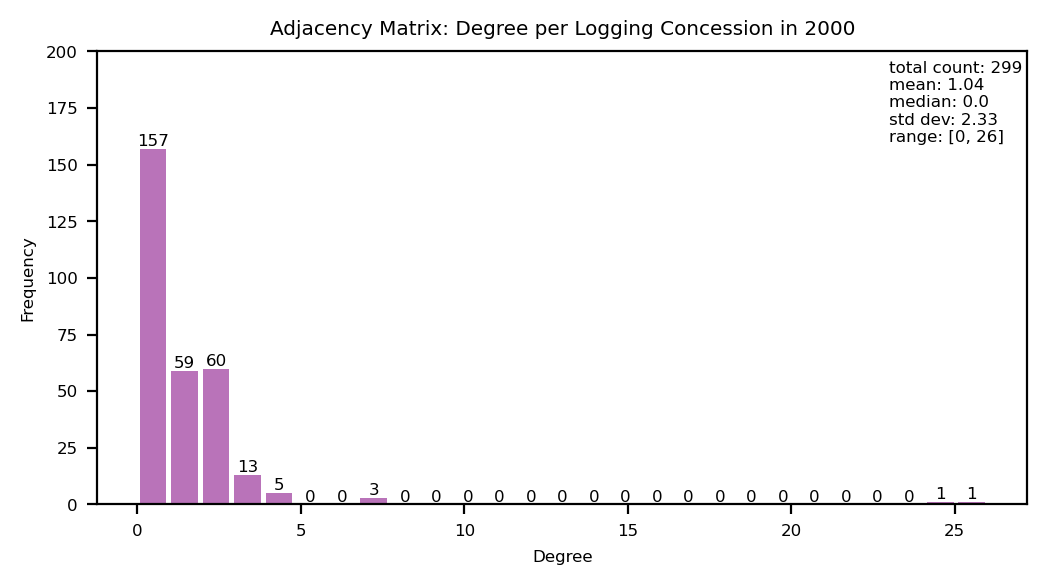

236


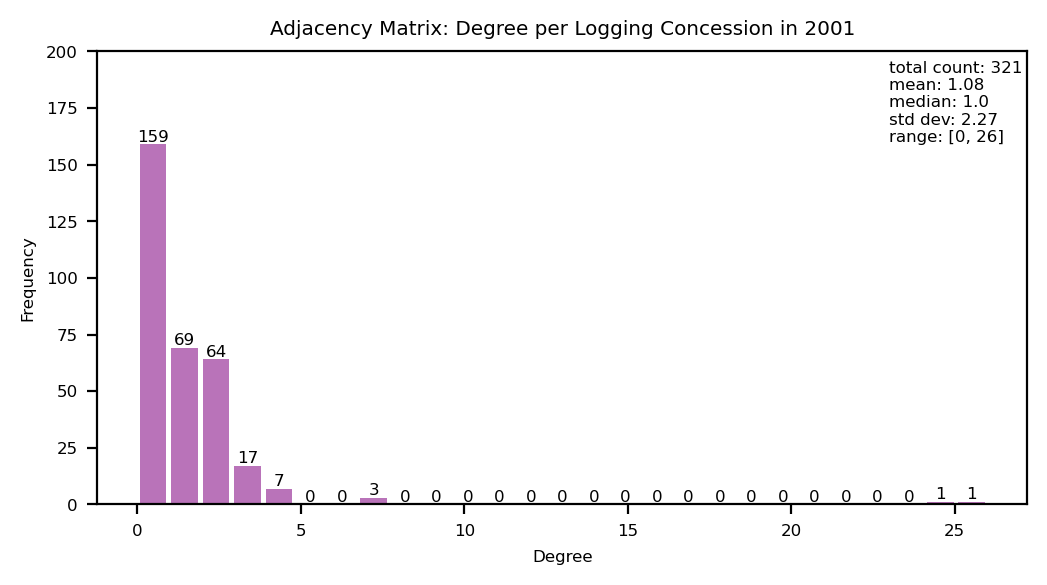

229


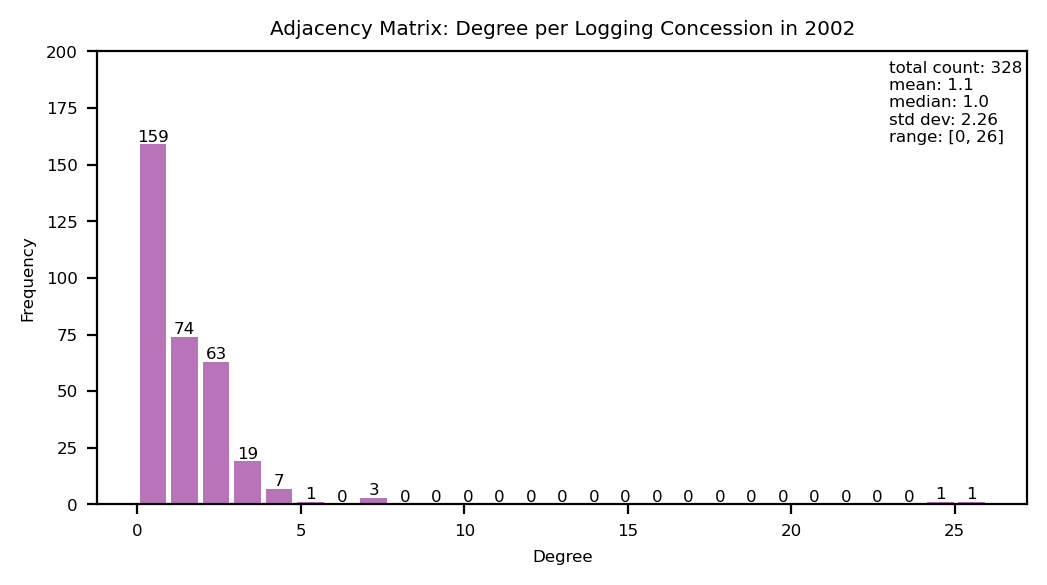

229


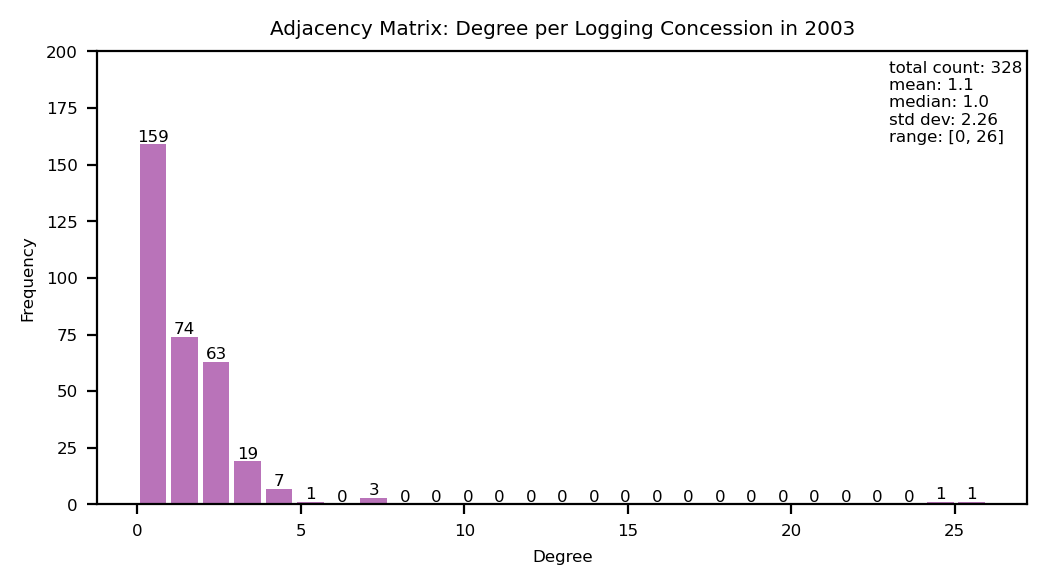

194


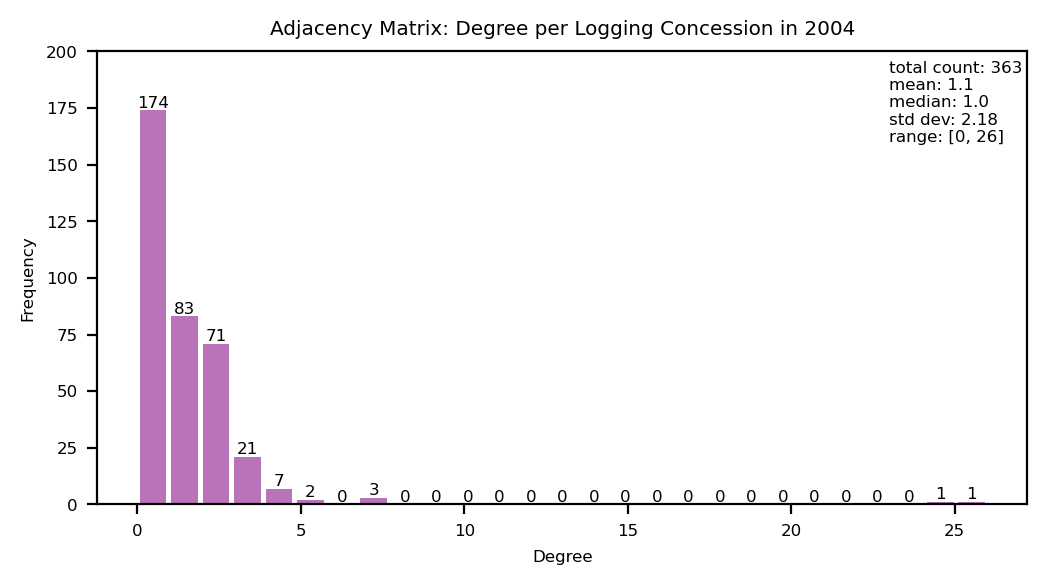

172


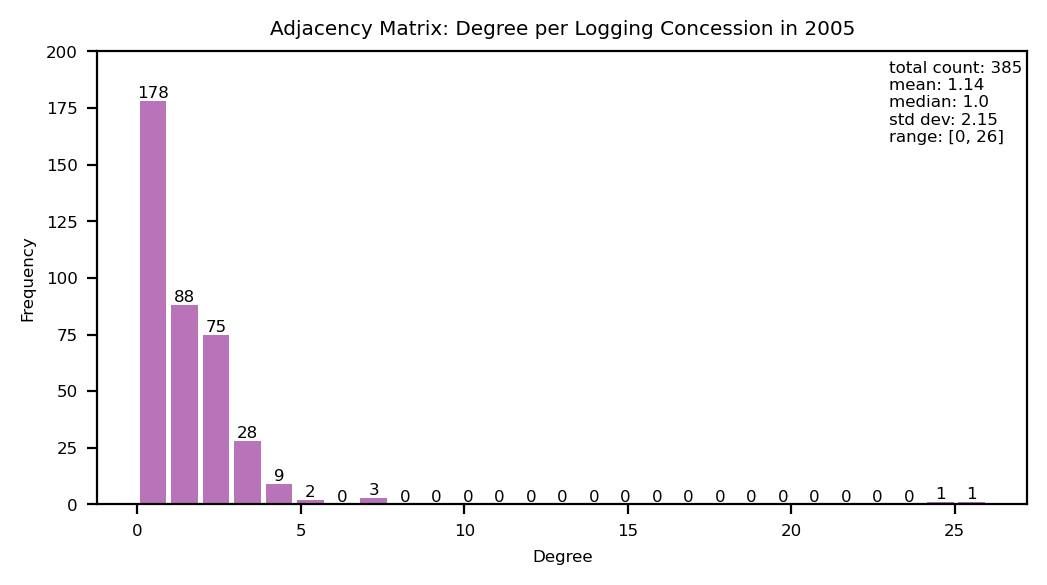

97


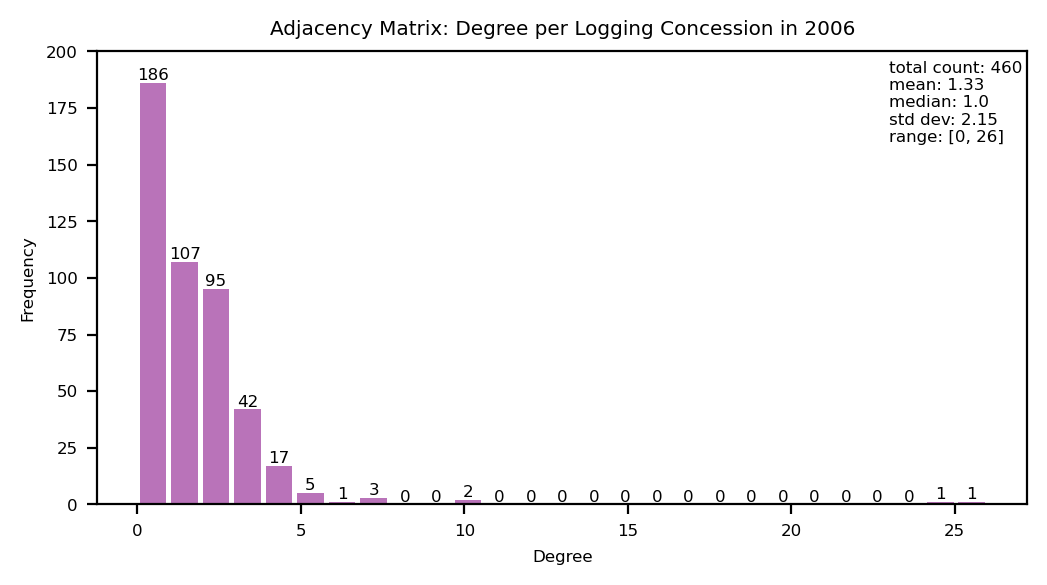

73


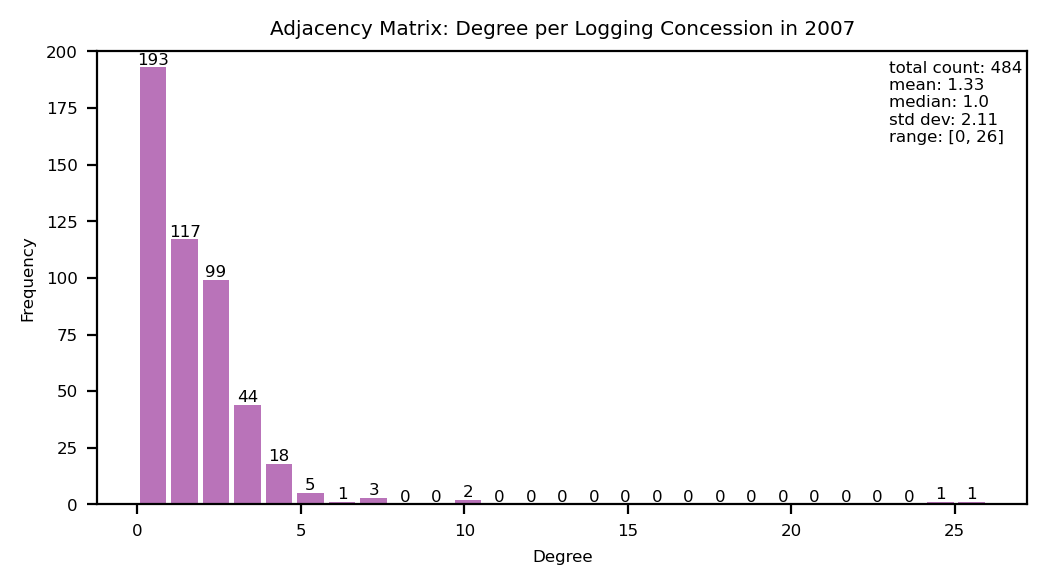

61


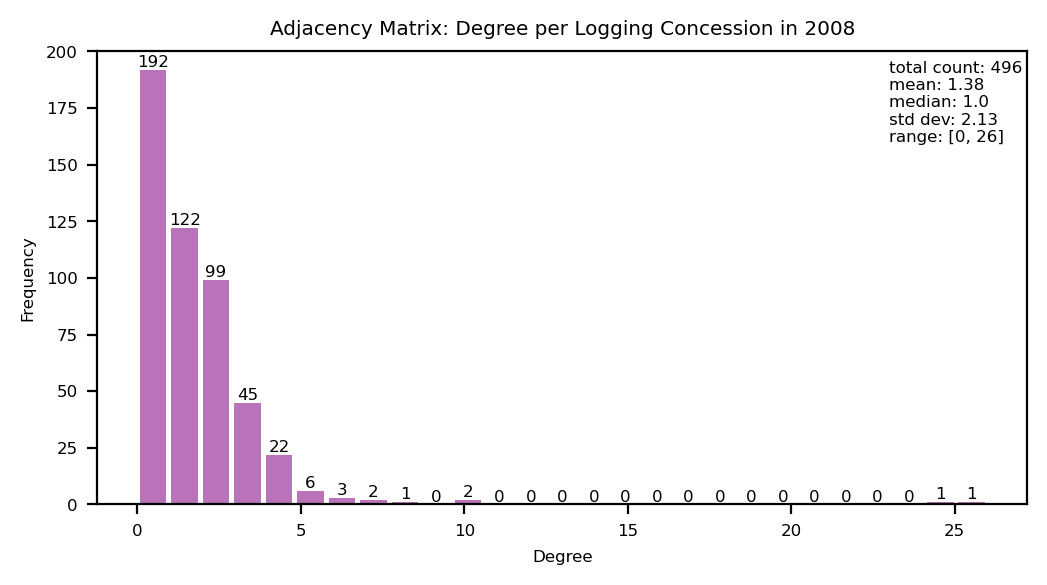

4


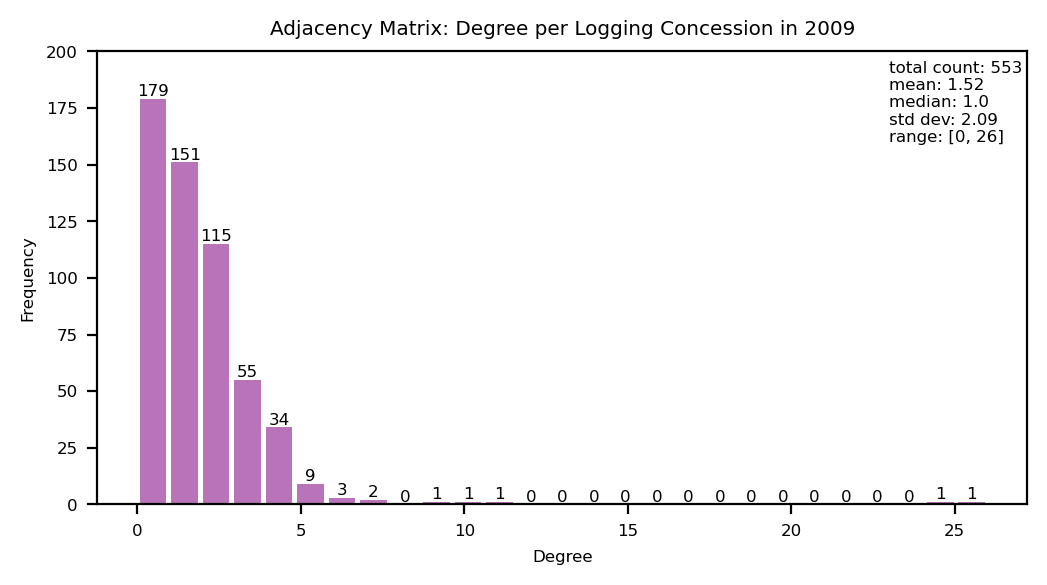

In [29]:
# plot all adjacencies matrices from 2000 to 2010

for year in range(2000, 2010):
    # list of num neighbors per polygon
    num_neighbors = sorted([np.count_nonzero(row == 1) for row in mats[str(year)]]) 

    # remove the concessions which aren't present at that time (0 neighbors)
    remove = len(skipped_per_year[str(year)])
    print(remove)
    make_hist(data = num_neighbors[remove:], title = "Adjacency Matrix: Degree per Logging Concession in " + str(year), ylim = (0, 200))
    
    

In [57]:
# save matrices as csv files
for year, mat in mats.items():
    adj_df = pd.DataFrame(mat)
    adj_df.to_csv("outputs/adjacencies/logging_"+year+".csv", header=False, index=False) # for more data processing
    # adj_df.to_excel("outputs/logging_concession_adjacencies_no_buffer.xlsx", header=True, index=True) # for visual inspection

# current "outputs/logging_concession_adjacencies_no_buffer.xlsx" is 2009

In [1]:
# number of neighbors the dataset has ranges from 0 to 11, with outliers of 25 and 26
np.unique(num_neighbors)

NameError: name 'np' is not defined

# Oil palm concessions
a_ij = 1 if oil palm concession i and oil palm concession j overlap, 0 elsewise or if i=j

<AxesSubplot:>

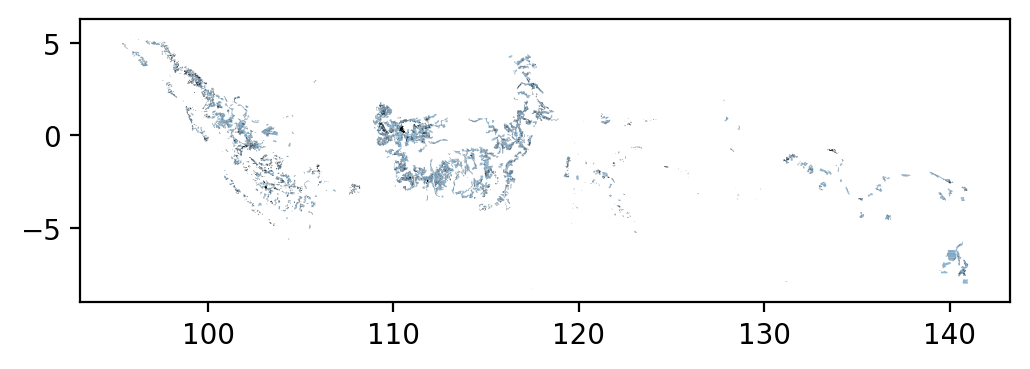

In [9]:
oilpalm_gdf = gpd.read_file("data/Greenpeace_Indonesia_Oil_Palm_Concessions_Map_Nov_2020.shp")
# One degree of latitude equals approximately 364,000 feet (69 miles), one minute equals 6,068 feet (1.15 miles), and one-second equals 101 feet. 
oilpalm_gdf["buffered"] = oilpalm_gdf.buffer(.00) # set buffer
ax = oilpalm_gdf.set_geometry('buffered').plot(alpha=.5) # saving the first plot as an axis and setting alpha (transparency) to 0.5
oilpalm_gdf.plot(ax=ax, facecolor = "none", edgecolor="black", linewidth=.02) # passing the first plot

In [10]:
# create adjacency matrix - 2d array
adj_mat_op = []
for indx, polygon in enumerate(oilpalm_gdf.loc[:, "geometry"]):
    row = oilpalm_gdf.set_geometry("buffered").intersects(polygon).astype(int) # compute adjacencies (1 is adjacent, 0 elsewise)
    row[indx] = 0 # region should not be considered adjacent to itself
    adj_mat_op.append(np.array(row))
# adj_mat

In [15]:
adj_op_df = pd.DataFrame(adj_mat_op)
adj_op_df.to_csv("outputs/oil_palm_concession_adjacencies_no_buffer.csv", header=False, index=False) # export

plot of degree vs frequency based on adjacency matrix for oil palm concessions

results:
- very right skewed
- just like for logging palm, most concessions have a few amount of neighbors

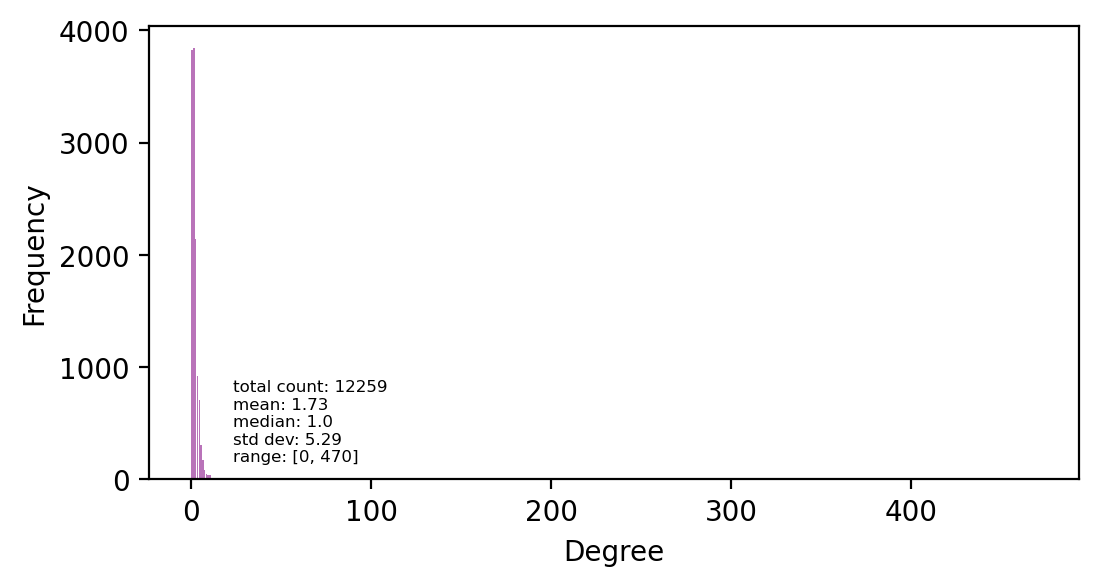

In [24]:
sums = [sum(row) for row in adj_mat_op]
make_hist(sums, show_bar_label=False)

# logging vs oil palm concessions
entries in matrix A is defined by

rows: logging concessions

cols: oil palm concessions

a_ij = 1 if logging concession i and oil palm concession j overlap, 0 else 

In [16]:
# create adjacency matrix - 2d np array
# rows: logging concessions
# cols: oil palm concessions
adj_mat_op_logging = []
for indx, polygon in enumerate(gdf.loc[:, "geometry"]):
    row = oilpalm_gdf.set_geometry("buffered").intersects(polygon).astype(int) # compute adjacencies (1 is adjacent, 0 elsewise)
    row[indx] = 0 # region should not be considered adjacent to itself
    adj_mat_op_logging.append(np.array(row))


In [19]:
adj_op_df = pd.DataFrame(adj_mat_op_logging)
adj_op_df.to_csv("outputs/logging_vs_oil_palm_concession_adjacencies_no_buffer.csv", header=False, index=False) # export